# CAS AML Thesis

https://www.kaggle.com/code/mrsohelranapro/car-object-detection-yolov-x-models


https://www.kaggle.com/code/maxkav/yolov5-tutorial-train-with-custom-data

https://stackoverflow.com/questions/74516330/why-am-i-getting-assertionerror-train-no-labels-found-in-content-dataset-test


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/drtophop/CASAML-Thesis/blob/main/CAS_AML_Yolo_HopV7.ipynb)

In [1]:
import os
import  time, random
import pandas as pd

import torch

from IPython import display
from IPython.display import clear_output
from pathlib import Path
import yaml
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import io
import os
import cv2
import json

import shutil
from tqdm.auto import tqdm

import numpy as np
from sklearn.model_selection import train_test_split

from IPython.display import Image, clear_output


%matplotlib inline



In [2]:
path_main = os.getcwd()
path_yoloset = f'{path_main}/car-object-detection/data'

In [3]:
# Delete the temporary directory and its contents


dirs_to_delete = ['car-object-detection', 'yolov5', 'test', 'tmp', 'train', 'valid', 'yolov5_train']

for dir_to_delete in dirs_to_delete:
    path_del = os.path.join(path_main, dir_to_delete)
    if os.path.exists(path_del):
        shutil.rmtree(path_del)

files_to_delete = ['data.yaml','yolov5m6.pt']

for file_to_delete in files_to_delete:
    file_del = os.path.join(path_main, file_to_delete)
    if os.path.exists(file_del):
        os.remove(file_del)



In [4]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 15978, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 15978 (delta 89), reused 118 (delta 75), pack-reused 15831
Receiving objects: 100% (15978/15978), 14.61 MiB | 17.25 MiB/s, done.
Resolving deltas: 100% (10958/10958), done.


In [5]:
!pip install -qr yolov5/requirements.txt

In [6]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


You can create a Kaggle API token from your Kaggle account and put this file in .kaggle directory your home directory. Alternately you may iser Kaggle API command

In [7]:
import opendatasets as od

od.download('https://www.kaggle.com/datasets/sshikamaru/car-object-detection/download?datasetVersionNumber=2')


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: drtophop
Your Kaggle Key: ··········


100%|██████████| 112M/112M [00:07<00:00, 15.2MB/s]


In [8]:
print(f'does path_main exist: {os.path.exists(path_main)}')
print(f'does path_yoloset exist: {os.path.exists(path_yoloset)}')

does path_main exist: True
does path_yoloset exist: True


In [9]:
PROJECT_NAME = "yolov5_train"
BASE_MODEL = "yolov5m6.pt"
TRAIN_BATCH = 32
TRAIN_EPOCHS = 20
VAL_BATCH = 64


In [10]:
img_h, img_w, num_channels = (380, 676, 3)

df = pd.read_csv(f'{path_yoloset}/train_solution_bounding_boxes (1).csv')

df.rename(columns={'image':'image_id'}, inplace=True)
df['image_id'] = df['image_id'].apply(lambda x: x.split('.')[0])
df['x_center'] = (df['xmin'] + df['xmax'])/2
df['y_center'] = (df['ymin'] + df['ymax'])/2
df['w'] = df['xmax'] - df['xmin']
df['h'] = df['ymax'] - df['ymin']
df['classes'] = 0
df['x_center'] = df['x_center']/img_w
df['w'] = df['w']/img_w
df['y_center'] = df['y_center']/img_h
df['h'] = df['h']/img_h
df.head()




,image_id,xmin,ymin,xmax,ymax,x_center,y_center,w,h,classes
0,vid_4_1000,281.259045,187.035071,327.727931,223.225547,0.450434,0.539817,0.068741,0.095238,0
1,vid_4_10000,15.163531,187.035071,120.329957,236.430180,0.100217,0.557191,0.155572,0.129987,0
2,vid_4_10040,239.192475,176.764801,361.968162,236.430180,0.444645,0.543678,0.181621,0.157014,0
3,vid_4_10020,496.483358,172.363256,630.020260,231.539575,0.833213,0.531451,0.197540,0.155727,0
4,vid_4_10060,16.630970,186.546010,132.558611,238.386422,0.110347,0.559122,0.171491,0.136422,0


In [11]:
index = list(set(df.image_id))
image = random.choice(index)
print("Image ID: %s"%(image))

img = cv2.imread(f'{path_yoloset}/training_images/{image}.jpg')
img.shape

Image ID: vid_4_14340


(380, 676, 3)

In [12]:
source = 'training_images'

for name, mini in tqdm(df.groupby('image_id')):
    if not os.path.exists(os.path.join(path_main, 'tmp', 'labels')):
        os.makedirs(os.path.join(path_main, 'tmp', 'labels'))

    with open(os.path.join(path_main, 'tmp', 'labels', '{}.txt'.format(name)), 'w+') as f:
        row = mini[['classes', 'x_center', 'y_center', 'w', 'h']].astype(float).values
        row = row.astype(str)
        for j in range(len(row)):
            text = ' '.join(row[j])
            f.write(text)
            f.write("\n")

    if not os.path.exists(os.path.join(path_main, 'tmp', 'images')):
        os.makedirs(os.path.join(path_main, 'tmp', 'images'))

    shutil.copy(
        os.path.join(path_yoloset, source, '{}.jpg'.format(name)),
        os.path.join(path_main, 'tmp', 'images', '{}.jpg'.format(name))
    )

  0%|          | 0/355 [00:00<?, ?it/s]

In [13]:
IMAGES_PATH = f'{path_main}/tmp/images/'
LABELS_PATH = f'{path_main}/tmp/labels/'

In [14]:
os.path.exists(IMAGES_PATH)

True

In [15]:
# Read labels
labels = os.listdir(LABELS_PATH)


# Split data
train, test = train_test_split(labels, test_size=0.15, shuffle=True)
valid, test = train_test_split(test, test_size=0.2)

print(f"train: {len(train)}; valid: {len(valid)}; test: {len(test)}")

train: 301; valid: 43; test: 11


In [16]:
os.makedirs(f'{path_main}/test/images')
os.makedirs(f'{path_main}/test/labels')
os.makedirs(f'{path_main}/train/images')
os.makedirs(f'{path_main}/train/labels')
os.makedirs(f'{path_main}/valid/images')
os.makedirs(f'{path_main}/valid/labels')

In [17]:
# Function to move files to directory
def move_files_to_dir(files, dirname):
    # Create target directories if they don't exist
    os.makedirs(f'{path_main}/{dirname}/images', exist_ok=True)
    os.makedirs(f'{path_main}/{dirname}/labels', exist_ok=True)

    for label_filename in files:
        image_filename = f"{label_filename[:-4]}.jpg"
        shutil.copy(f"{IMAGES_PATH}/{image_filename}", f"{path_main}/{dirname}/images/{image_filename}")
        shutil.copy(f"{LABELS_PATH}/{label_filename}", f"{path_main}/{dirname}/labels/{label_filename}")


# Move splits to folders
move_files_to_dir(train, "train")
move_files_to_dir(test, "test")
move_files_to_dir(valid, "valid")



In [18]:
directories = ['train', 'test', 'valid']
subdirectories = ['images', 'labels']

for directory in directories:
    for subdirectory in subdirectories:
        path = os.path.join(path_main, directory, subdirectory)
        file_count = len(os.listdir(path))
        print(f"Number of files in {path}: {file_count}")

Number of files in /content/train/images: 301
Number of files in /content/train/labels: 301
Number of files in /content/test/images: 11
Number of files in /content/test/labels: 11
Number of files in /content/valid/images: 43
Number of files in /content/valid/labels: 43


In [19]:
train_path = f'{path_main}/train'
test_path = f'{path_main}/test'
valid_path  = f'{path_main}/valid'


In [20]:
test_path

'/content/test'

In [21]:
print(
    f"train: {train_path}\n"
    f"test: {test_path}\n"
    f"val: {valid_path}\n"
    f"nc: {1}\n"
    f"names: HopCar",
)

with open("data.yaml", "w") as file:
    yaml.dump({
        "train": train_path,
        "test": test_path,
        "val": valid_path,
        "nc": 1,
        "names": {0: "HopCar"}
    }, file)

train: /content/train
test: /content/test
val: /content/valid
nc: 1
names: HopCar


In [22]:
# Delete old results if exists
wildcard = f"{PROJECT_NAME}/feature_extraction*"
! rm -r $wildcard

rm: cannot remove 'yolov5_train/feature_extraction*': No such file or directory


In [23]:
!python yolov5/train.py --batch $TRAIN_BATCH --epochs $TRAIN_EPOCHS --data "data.yaml" --weights $BASE_MODEL --project $PROJECT_NAME --name 'feature_extraction' --cache --freeze 12


train: weights=yolov5m6.pt, cfg=, data=data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=20, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5_train, name=feature_extraction, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[12], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-178-ga199480 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015,

In [24]:
# Delete old results
wildcard = f"{PROJECT_NAME}/validation_on_test_data*"
! rm -r $wildcard

rm: cannot remove 'yolov5_train/validation_on_test_data*': No such file or directory


In [25]:
WEIGHTS_BEST = f"{PROJECT_NAME}/feature_extraction/weights/best.pt"
! python yolov5/val.py --weights $WEIGHTS_BEST --batch $VAL_BATCH --data 'data.yaml' --task test --project $PROJECT_NAME --name 'validation_on_test_data' --augment

val: data=data.yaml, weights=['yolov5_train/feature_extraction/weights/best.pt'], batch_size=64, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=True, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5_train, name=validation_on_test_data, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-178-ga199480 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 276 layers, 35248920 parameters, 0 gradients, 48.9 GFLOPs
test: Scanning /content/test/labels... 11 images, 0 backgrounds, 0 corrupt: 100% 11/11 [00:00<00:00, 935.09it/s]
test: New cache created: /content/test/labels.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 1/1 [00:00<00:00,  1.24it/s]
                   all         11         16      0.997      0.938      0.935      0.607
Speed: 0.2ms pre-process, 42.4ms inference, 1.4ms N

In [26]:
# Delete old results
wildcard = f"{PROJECT_NAME}/detect_test*"
! rm -r $wildcard

rm: cannot remove 'yolov5_train/detect_test*': No such file or directory


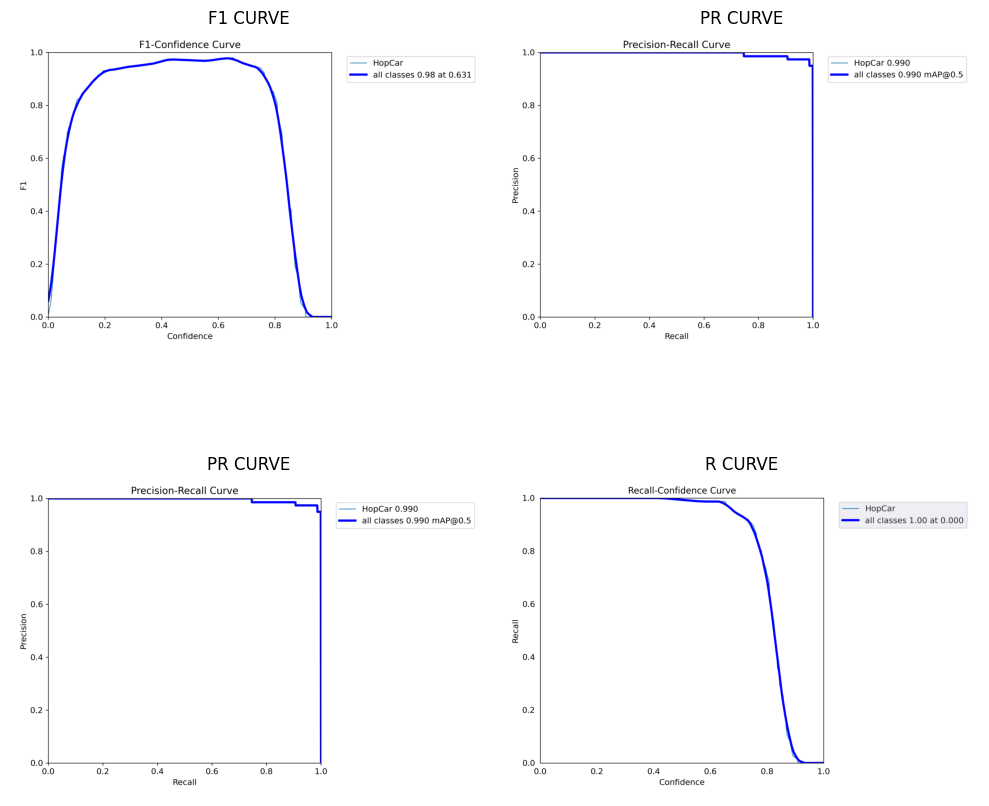

In [27]:
pics = ['F1_curve.png', 'PR_curve.png', 'PR_curve.png', 'R_curve.png']

fig, axs = plt.subplots(2, 2,figsize=(10, 10))

for i, pic in enumerate(pics):
    image_path = f'{PROJECT_NAME}/feature_extraction/{pic}'
    img = mpimg.imread(image_path)
    row = i // 2
    col = i % 2
    axs[row, col].imshow(img)
    axs[row, col].axis('off')
    axs[row, col].set_title(pic[:-4].replace("_", " ").upper())

plt.tight_layout()
plt.show()





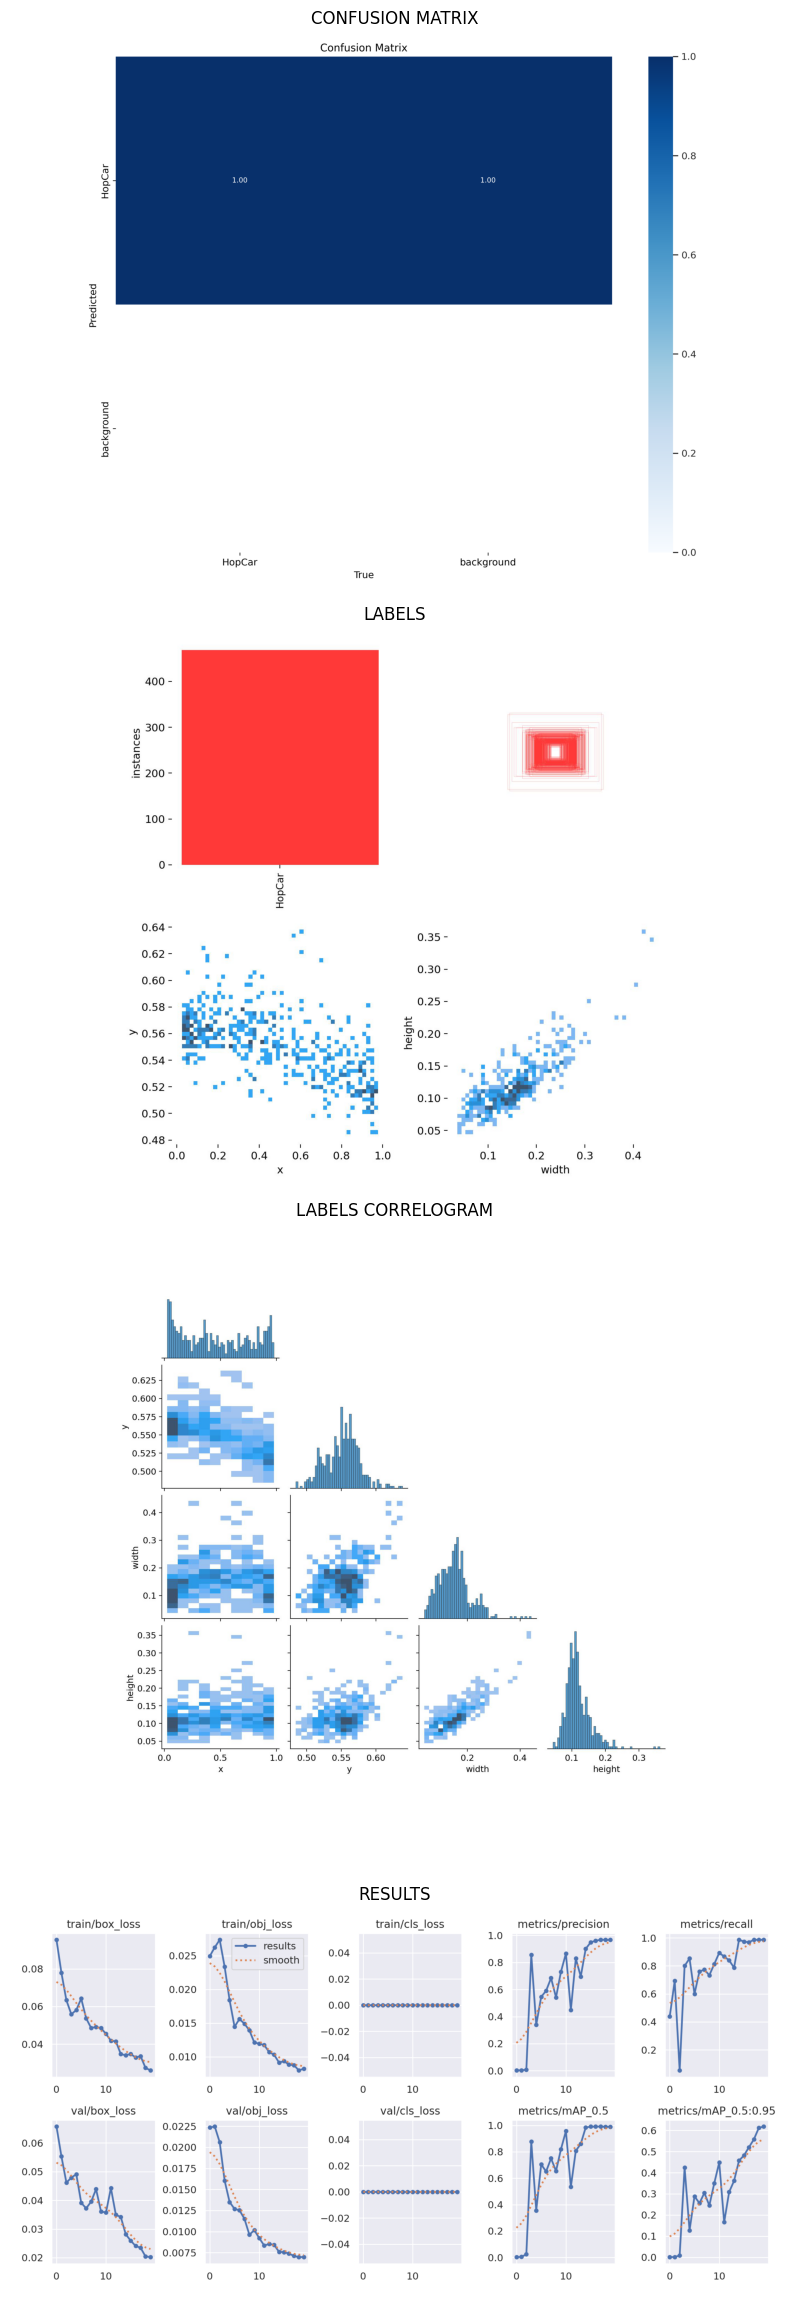

In [28]:
pics = ['confusion_matrix.png', 'labels.jpg', 'labels_correlogram.jpg', 'results.png']

fig, axs = plt.subplots(4, 1, figsize=(8, 24))  # Adjust figsize as desired

for i, pic in enumerate(pics):
    image_path = f'{PROJECT_NAME}/feature_extraction/{pic}'
    img = mpimg.imread(image_path)
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(pic[:-4].replace("_", " ").upper())

plt.tight_layout()
plt.show()

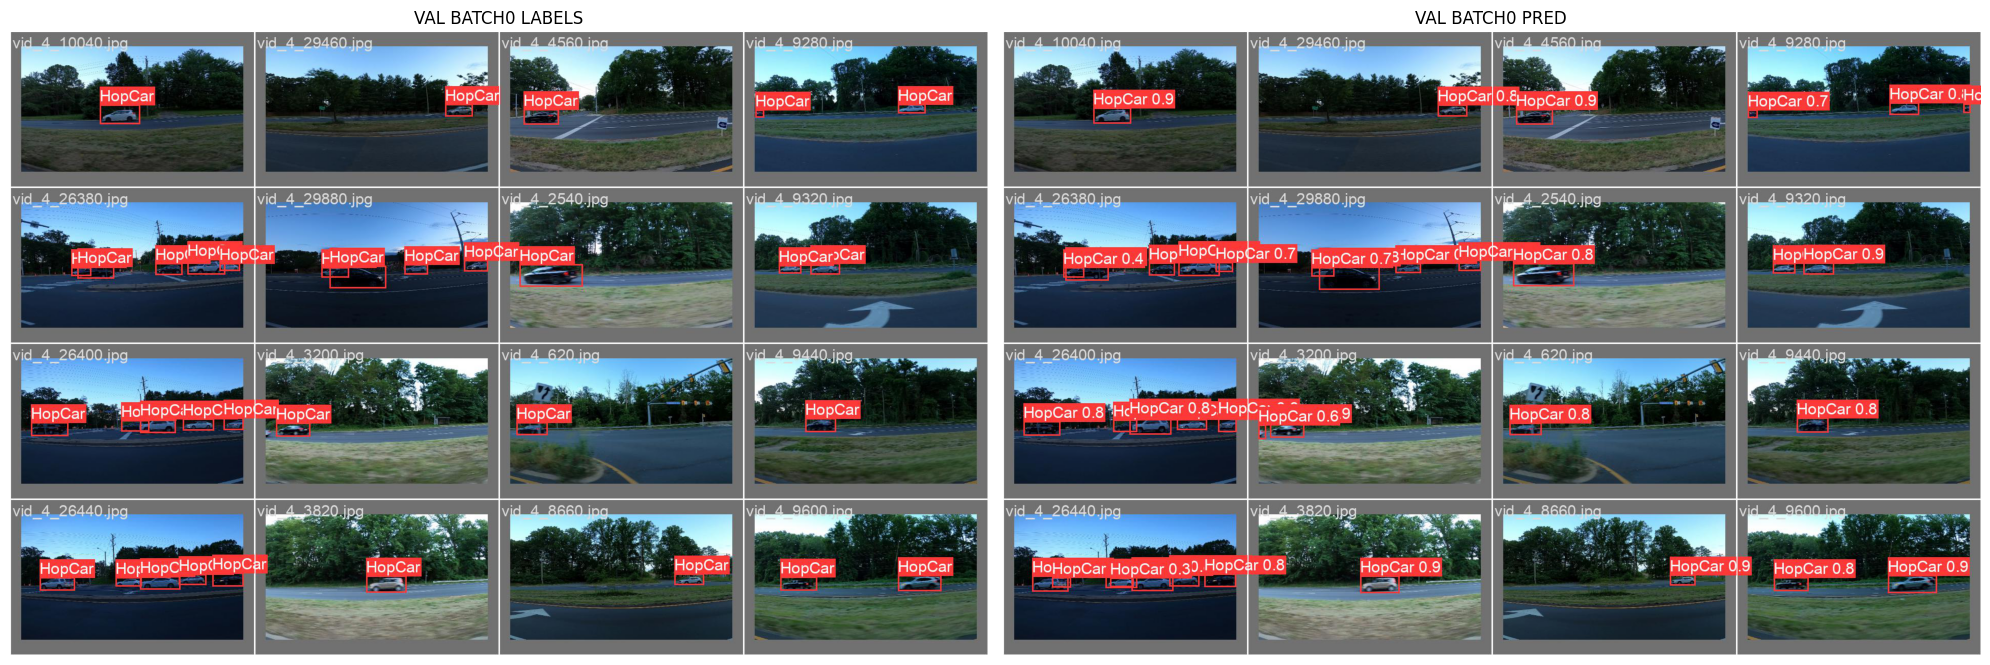

In [29]:
pics = ['val_batch0_labels.jpg', 'val_batch0_pred.jpg']

fig, axs = plt.subplots(1, 2, figsize=(20, 10))  # Adjust figsize as desired

for i, pic in enumerate(pics):
    image_path = f'{PROJECT_NAME}/feature_extraction/{pic}'
    img = mpimg.imread(image_path)
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(pic[:-4].replace("_", " ").upper())

plt.tight_layout()
plt.show()

In [30]:
#!python yolov5/detect.py --weights $WEIGHTS_BEST --conf 0.6 --source '/content/tmp/images' --project $PROJECT_NAME --name 'detect_test' --augment --line=3

!python yolov5/detect.py --weights $WEIGHTS_BEST --conf 0.6 --source '/content/tmp/images' --project $PROJECT_NAME --name 'detect_test' --augment --line=3 --save-txt


detect: weights=['yolov5_train/feature_extraction/weights/best.pt'], source=/content/tmp/images, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.6, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=True, visualize=False, update=False, project=yolov5_train, name=detect_test, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-178-ga199480 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 276 layers, 35248920 parameters, 0 gradients, 48.9 GFLOPs
image 1/355 /content/tmp/images/vid_4_1000.jpg: 384x640 1 HopCar, 177.1ms
image 2/355 /content/tmp/images/vid_4_10000.jpg: 384x640 1 HopCar, 58.1ms
image 3/355 /content/tmp/images/vid_4_10020.jpg: 384x640 1 HopCar, 51.9ms
image 4/355 /content/tmp/images/vid_4_10040.jpg: 384x640 1 HopCar, 43.0ms
image 5/355 /conten

In [31]:
os.path.exists('yolov5_train/detect_test')

True

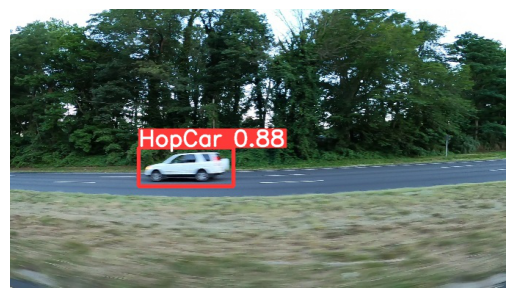

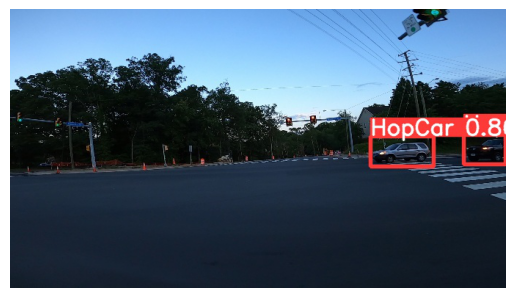

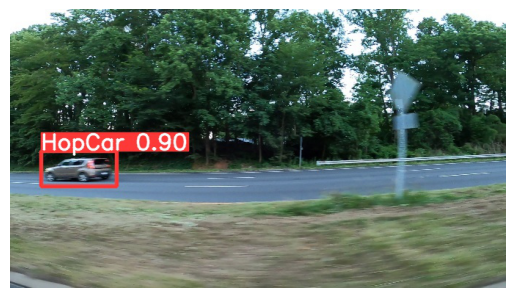

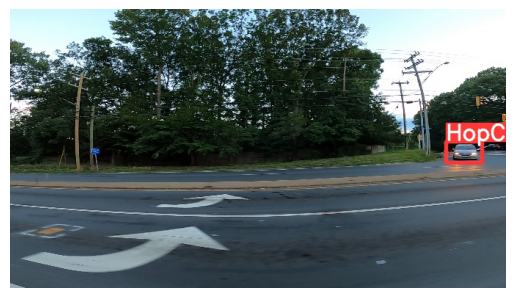

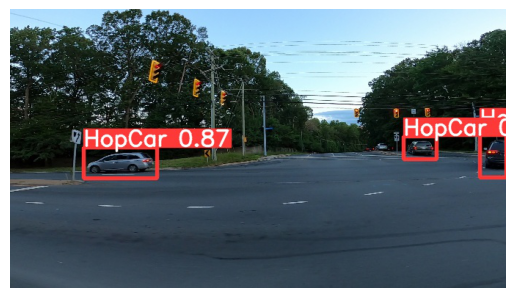

In [32]:

import random


directory = "yolov5_train/detect_test"
jpg_files = [file for file in os.listdir(directory) if file.endswith(".jpg")]
random_files = random.sample(jpg_files, 5)

for file in random_files:
    image_path = os.path.join(directory, file)
    image = mpimg.imread(image_path)
    plt.imshow(image)
    plt.axis("off")
    plt.show()

In [33]:
import cv2

# Path to the output folder for cropped images
output_folder = "cropped_images"
os.makedirs(output_folder, exist_ok=True)

# Path to the detection results file
detection_results = "yolov5_train/detect_test/results.txt"
print(os.path.exists(detection_results))

# Path to the directory containing the original images
image_folder = "/content/tmp/images"

# Read the detection results file
with open(detection_results, "r") as file:
    lines = file.readlines()

# Process each line of the detection results file
for line in lines[1:]:
    line_parts = line.strip().split(" ")
    image_name = line_parts[0]
    image_path = os.path.join(image_folder, image_name)
    image = cv2.imread(image_path)
    height, width, _ = image.shape

    num_boxes = int(line_parts[1])
    boxes = []
    for i in range(num_boxes):
        box = line_parts[2 + 6 * i: 6 * (i + 1) + 2]
        boxes.append(box)

    # Crop and save the images using the bounding boxes
    for box in boxes:
        class_id, confidence, x_min, y_min, x_max, y_max = box
        x_min = int(float(x_min) * width)
        y_min = int(float(y_min) * height)
        x_max = int(float(x_max) * width)
        y_max = int(float(y_max) * height)

        cropped_img = image[y_min:y_max, x_min:x_max]

        cropped_img_name = f"{image_name[:-4]}_{class_id}.jpg"
        cropped_img_path = os.path.join(output_folder, cropped_img_name)
        cv2.imwrite(cropped_img_path, cropped_img)

False


FileNotFoundError: ignored